# Problem Set 2, due September 18 at 11:59pm

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on bCourses). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from bCourses. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|

---

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [2]:
# your code here
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
progresa_df = pd.read_csv('progresa_sample.csv')
print(progresa_df.progresa)

0            0
1            0
2            0
3            0
4            0
5            0
6        basal
7        basal
8        basal
9        basal
10       basal
11       basal
12       basal
13       basal
14       basal
15       basal
16       basal
17       basal
18       basal
19       basal
20       basal
21       basal
22       basal
23       basal
24       basal
25       basal
26       basal
27       basal
28       basal
29       basal
         ...  
77220    basal
77221    basal
77222    basal
77223    basal
77224    basal
77225    basal
77226    basal
77227    basal
77228    basal
77229    basal
77230    basal
77231    basal
77232    basal
77233    basal
77234    basal
77235    basal
77236    basal
77237    basal
77238    basal
77239    basal
77240    basal
77241    basal
77242    basal
77243    basal
77244    basal
77245    basal
77246    basal
77247    basal
77248    basal
77249    basal
Name: progresa, Length: 77250, dtype: object


In [4]:
print('poor levels: ', progresa_df['poor'].unique().tolist())
print('progresa levels: ', progresa_df['progresa'].unique().tolist())

poor levels:  ['pobre', 'no pobre']
progresa levels:  ['0', 'basal']


In [5]:
# create dictionary to convert 'poor' values to int
poor_dict = {"no pobre":0 ,"pobre":1} 
# create new variable with pobre dictionary
progresa_df['poor'] = progresa_df['poor'].replace(poor_dict)
# # convert poor_int to integer
progresa_df['poor'] = pd.to_numeric(progresa_df['poor'])



In [6]:
# create dictionary to convert 'progresa' values to int
progresa_dict = {"0":0 , "basal":1}

# create new variable with pobre dictionary
progresa_df['progresa'] = progresa_df['progresa'].replace(progresa_dict)
# convert poor_int to integer
progresa_df['progresa'] = pd.to_numeric(progresa_df['progresa'])

In [7]:
# drop unnecessary variables (year, folnmum, village)
progresa_demog_df = progresa_df.drop(['year', 'village', 'folnum'], 1)

In [8]:
# print summary stats table
pd.options.display.float_format = '{:8.2f}'.format # Set formating for displaying tables
progresa_demog_df.describe().T[['mean','std','min','max']].sort_index()

,mean,std,min,max
age,11.37,3.17,6.00,17.00
dist_cap,147.67,76.06,9.47,359.77
dist_sec,2.42,2.23,0.00,14.88
fam_n,7.22,2.35,1.00,24.00
grc,3.96,2.50,0.00,14.00
grc97,3.71,2.57,0.00,14.00
hohage,44.44,11.62,15.00,98.00
hohedu,2.77,2.66,0.00,20.00
hohsex,0.93,0.26,0.00,1.00
hohwag,586.99,788.13,0.00,14000.00


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [9]:
# your code here
# Generate data frame with only 1997 data and with only poor households
pre_poor_df = progresa_df[(progresa_df['year'] == 97) & (progresa_df['poor'] == 1)]

# create treatment data frame with poor households
pre_treat = pre_poor_df[pre_poor_df['progresa'] == 1]

# create control data frame with poor households
pre_control = pre_poor_df[pre_poor_df['progresa'] == 0]

In [10]:
# drop unecessary variables for demographic characteristics
pre_treat_demog = pre_treat.drop(['poor', 'progresa', 'year', 'village', 'folnum', 'sc', 'grc'], 1)
pre_control_demog = pre_control.drop(['poor', 'progresa', 'year', 'village', 'folnum', 'sc', 'grc'], 1)

In [11]:
# Create data frame with p-values
means_t = []
means_c = []
diffs = []
pvalues = []
demogvars = pre_control_demog.columns.tolist()
for var in demogvars:
    #print var
    x_t = pre_treat_demog[var].dropna().mean()
    x_c = pre_control_demog[var].dropna().mean()   
    diff = x_t - x_c
    result = stats.ttest_ind(pre_treat_demog[var].dropna(), pre_control_demog[var].dropna())
    means_t.append(x_t)
    means_c.append(x_c)
    diffs.append(diff)
    pvalues.append(result[1])

mean_compare = pd.DataFrame({'Variable name':demogvars,
                             'Average value (Treatment villages)':means_t,
                             'Average value (Control villages)':means_c,
                             'Difference (Treat - Control)':diffs,
                             'p-value':pvalues})

In [12]:
pd.options.display.float_format = '{:1,.4f}'.format
mean_compare[['Variable name', 'Average value (Treatment villages)', 'Average value (Control villages)', \
          'Difference (Treat - Control)', 'p-value']].sort_values('Variable name')

,Variable name,Average value (Treatment villages),Average value (Control villages),Difference (Treat - Control),p-value
11,age,10.7170,10.7420,-0.0250,0.4786
5,dist_cap,150.8291,153.7697,-2.9407,0.0008
2,dist_sec,2.4531,2.5077,-0.0545,0.0357
3,fam_n,7.2813,7.3025,-0.0211,0.4271
12,grc97,3.5316,3.5430,-0.0115,0.6890
10,hohage,43.6488,44.2769,-0.6281,0.0000
6,hohedu,2.6631,2.5903,0.0728,0.0111
9,hohsex,0.9247,0.9229,0.0017,0.5712
7,hohwag,544.3395,573.1636,-28.8240,0.0003
1,indig,0.3260,0.3322,-0.0062,0.2454


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

* A. Yes, treatment and control villages have several statistically significant differences. There are several variables for which we observe statistically significant differences between poor households in treatment and control village at the time of the baseline. Households in PROGRESA villages differ from control households in that they more likely to be closer to the capital, closer to a secondary school, and a greater distance from an urban center. Moreover, the head of household in PROGRESA villages are on average younger, have more education, and earn a lower wage. PROGRESA households also have lower socioeconomic status, as measured by the welfare_index and children are more likely to be male.

* B. When treatment and control villages are different at baseline, it suggests that treatment assignment was not purely random. Due to random chance, we might expect that the occasional variable might not be balanced between treatment and control, even under perfect randomization. These baseline differences are important to note. It is possible that the differences could have arisen due to random chance, but unlikely. When a large number of characteristics appear to be systematically different between treatment and control (as is the case in our sample), we should be concerned that certain types of villages were systematically assigned to treatment, while others were assigned to control.

* C. When treatment assignment is not random, the simple difference in outcomes between treatment and control units is no longer an unbiased estimate of the treatment effect. Since T and C villages were different before the intervention, we might expect they would also be different after the intervention, *even in the absence of the intervention.* Thus, we would be incorrectly attributing a treatment effect to the intervention, when in reality it was due to pre-existing differences between the treatment and control villages. Therefore, when we conduct our analysis of the impact of PROGRESA we will want to control for differences in village and household characteristics at baseline.

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

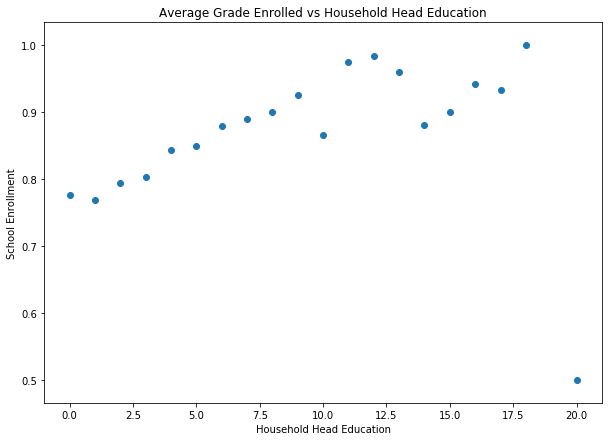

In [13]:
progresa_df97=progresa_df[(progresa_df['year'] == 97)]
progresa_df97_en=pd.DataFrame(progresa_df97.groupby('hohedu')['sc'].mean()).reset_index(inplace=False)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.scatter(progresa_df97_en['hohedu'],progresa_df97_en['sc'])
plt.ylabel("School Enrollment")
plt.xlabel("Household Head Education")
plt.title("Average Grade Enrolled vs Household Head Education")
plt.show()

There is a positive linear relationship between school enrollment in 1997 and the education of the head of household. In other words, in households where the household head has more education, it is more likely that the child will be enrolled in school.  This is a common correlation found in developing and developed countries alike.

### 1.5 Graphical exploration, part 2

Visualize the distribution of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). Does there appear to be a difference? Is this difference statistically significant?

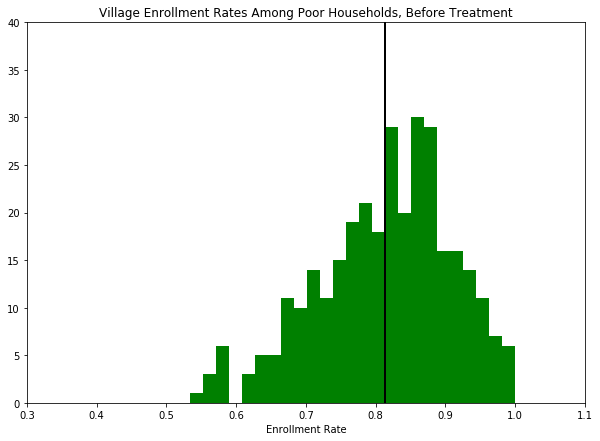

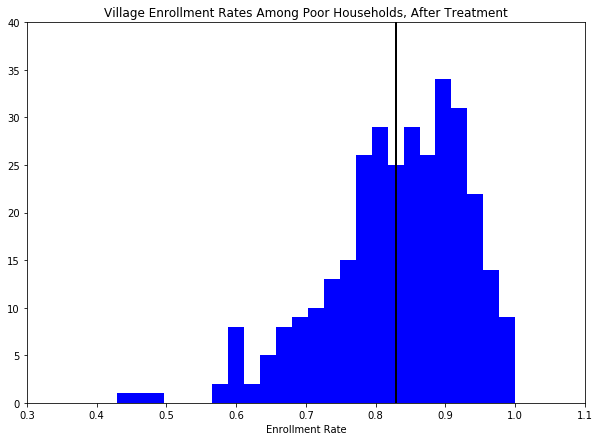

In [14]:
# Your code here
#print progresa_df.shape
poor_treatment97 = progresa_df[(progresa_df['year'] == 97) &
                               (progresa_df['progresa'] == 1) &
                               (progresa_df['poor'] == 1)]
poor_treatment98 = progresa_df[(progresa_df['year'] == 98) &
                               (progresa_df['progresa'] == 1) &
                               (progresa_df['poor'] == 1)]

poor_treatment97_en=pd.DataFrame(poor_treatment97.groupby('village')['sc'].mean())
poor_treatment98_en=pd.DataFrame(poor_treatment98.groupby('village')['sc'].mean())
# Histogram for Pre (1997)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.ylim(ymax=45)
plt.hist(poor_treatment97_en.values, color="green", bins=25)
plt.title("Village Enrollment Rates Among Poor Households, Before Treatment")
plt.xlabel("Enrollment Rate")

pre_mean = poor_treatment97_en['sc'].mean()
plt.axvline(pre_mean, color="black", linewidth=2)
plt.axis((0.3,1.1,0,40))
plt.show()

# Histogram for Post (1998)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.ylim(ymax=45)
plt.hist(poor_treatment98_en.values, color="Blue", bins=25)
plt.title("Village Enrollment Rates Among Poor Households, After Treatment")
plt.xlabel("Enrollment Rate")
post_mean = poor_treatment98_en['sc'].mean()
plt.axvline(post_mean, color="black", linewidth=2)
plt.axis((0.3,1.1,0,40))
plt.show()

In [15]:
t, p = stats.ttest_ind(poor_treatment97_en, poor_treatment98_en)
print('Difference:', (post_mean - pre_mean))
print('p-value:', p)

Difference: 0.0156967932034231
p-value: [0.0442487]


On average, enrollment rates in treated villages increased by 1.5% between 1997 and 1998. This difference in means was statistically significant at standard levels of stastical significance (p<0.05). Note that this doesn't necessary mean that the treatment had an impact, it just says that average enrollment rates in treated villages were higher in the period post-treatment than they were in the period pre-treatment.

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. We will focus on the impact of the program on the poor (those with poor=='pobre'), since only the poor were eligible to receive the PROGRESA assistance.

### 2.1 Simple differences: T-test

Begin by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment), calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages. Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [16]:
df98 = progresa_df[progresa_df['year'] == 98]
df97 = progresa_df[progresa_df['year'] == 97]

treated98 = df98[(df98.progresa == 1) & (df98.poor == 1)]
control98 = df98[(df98.progresa == 0) & (df98.poor == 1)]
mean_t98 = treated98.sc.mean()
mean_c98 = control98.sc.mean()

print('Control average (98): {}'.format(mean_c98))
print('Treated average (98): {}'.format(mean_t98))
print('Difference: {}'.format(mean_t98-mean_c98))
tstat, pval = stats.ttest_ind(treated98.sc.dropna(), control98.sc.dropna())
print('P-value: {}'.format(pval))

Control average (98): 0.807636956730308
Treated average (98): 0.8464791213954308
Difference: 0.0388421646651228
P-value: 6.636344447523235e-17


Enrollment rates among the poor in 1998 in the treated villages were nearly four percentage points higher than average enrollment rates in the control villages. These differences are statistically significant, so the "simple differences" method makes it look like Progresa  had an effect on enrollment. However, we are skeptical of these estimates, since we know that treatment villages were systematically different from control villages, even before the PROGRESA program arrived.

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. For now, do not include any other variables in your regression. Discuss the following:

* Based on this model, how much did Progresa increase or decrease the likelihood of a child enrolling? Make sure you express you answer in a sentence that your grandmother could understand, using appropriate units.
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [17]:
poor98 = df98[df98.poor == 1]
ols1 = smf.ols(formula = "sc ~ progresa", data=poor98, missing='drop').fit()
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Mon, 10 Feb 2020   Prob (F-statistic):           6.64e-17
Time:                        17:08:52   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.0

* The regression indicates that progresa increased enrollment of the poor by 3.88 percentage points
* Our estimate of the "simple differences" treatment effect of Progresa is identical to the estimate from 2.1
* Based on this regression model, we can reject the null hypothesis. The estimate of 3.88 percentage points is highly significant (p<0.01).
* The counterfactual assumption is that, in the absence of treatment, there would have been no statistically significant differences in schooling enrollment between the treatment and control group

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, welfare index, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [18]:
formula2 = "sc ~ progresa + age + dist_sec + C(sex) + hohedu + fam_n"
ols2 = smf.ols(formula2, data=poor98, missing='drop').fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     1644.
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:08:53   Log-Likelihood:                -7742.1
No. Observations:               27440   AIC:                         1.550e+04
Df Residuals:                   27433   BIC:                         1.556e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5399      0.011    137.651

* Including control variables deceases the estimated coefficient on the treatment effect
* There is very little effect on the standard error
* Controlling for other observable factors decreased the estimated treatment effect - or put differently, without controlling for other factors, the estimates of the treatment effectin 2.2 were likely *over*-estimates of the true treatment effect. This is likely due to the fact that other factors were correlated with both treatment and outcomes (as we saw in 1.2).

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [22]:
poor_df = progresa_df[progresa_df['poor'] == 1]
poor_df_mean_sc = poor_df.groupby(['year', 'progresa'])['sc'].mean()
print(poor_df_mean_sc)
print(poor_df)
dd_estimate = (poor_df_mean_sc[3] - poor_df_mean_sc[2]) - (poor_df_mean_sc[1] - poor_df_mean_sc[0])
print(dd_estimate)

year  progresa
97    0          0.8152
      1          0.8227
98    0          0.8076
      1          0.8465
Name: sc, dtype: float64
       year    sex  indig  dist_sec     sc    grc  fam_n  min_dist  dist_cap  \
0        97 0.0000 0.0000    4.4730 1.0000 7.0000      7   21.1684   21.1684   
1        98 0.0000 0.0000    4.4730 1.0000 8.0000      7   21.1684   21.1684   
2        97 1.0000 0.0000    4.4730 1.0000 6.0000      7   21.1684   21.1684   
3        98 1.0000 0.0000    4.4730 1.0000 7.0000      7   21.1684   21.1684   
4        97 0.0000 0.0000    4.4730 1.0000 2.0000      7   21.1684   21.1684   
5        98 0.0000 0.0000    4.4730 1.0000 3.0000      7   21.1684   21.1684   
6        97 0.0000 0.0000    3.1540 0.0000 6.0000      6  127.1148  154.1960   
7        98 0.0000 0.0000    3.1540 0.0000 6.0000      6  127.1148  154.1960   
8        97 1.0000 0.0000    3.3730 1.0000 2.0000      5   85.3003  105.8787   
9        98 1.0000 0.0000    3.3730 1.0000 2.0000      5   85.30

* Our double-different estimate is that PROGRESA increased enrolment by 3.13 percentage points. This estimate of the impact of PROGRESA is lower than the simple differences estimate from 2.3, and also lower than the simple difference estimate that controls for potentially confounding factors (2.4). Again, this all points to the fact that treated households were systematically different from control households, even in the absence of treatment. Most noticably, we previously estimated baseline differences in enrollment of 0.75%; of the various research designs we have tested, only the difference-in-difference estimator accounts for this.
* The counterfactual assumption is that in the absence of treatment, the difference in enrollment for poor households in the treatment group between 1997 and 1998 would be the same as the difference in enrollment for poor households in the control group between 1997 and 1998.  Another way of saying this is that we are assuming that there exist parallel trends over time in enrollment rates between treated and control villages.

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment effects of the program in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [20]:
poor_df = progresa_df[progresa_df.poor == 1].copy()
poor_df.year = np.where(poor_df.year == 97,0,1)
ols3 = smf.ols(formula='sc ~ age + C(sex) + fam_n + hohedu + progresa*year', data=poor_df, missing='drop').fit()
# note that in the above command [progresa*year] is a shorthand for [progresa + year + progresa X year] 
print(ols3.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     3106.
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:08:58   Log-Likelihood:                -17031.
No. Observations:               58352   AIC:                         3.408e+04
Df Residuals:                   58344   BIC:                         3.415e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4853      0.008    197.708

* Using a difference-in-difference regression, I estimate that the Progresa program increased enrollment of poor households by 3.18 percentage points (this is Progresa*year). Note that we further estimate that enrollment rates, in general, were 2.64 percentage points higher in 1998 (the coefficient on year) and that Progresa villages have on average 0.37 percentage points higher enrollment (the coefficient on Progresa). 
* Compared to the single differences, the estimate of the treatment effect is smaller.
* The estimated treatment effect is quite similar to that estimated in 2.4, but not identical. The differences result from the fact that in this regression we are also controlling for other observed characteristics of the household (such as age, hohedu, etc.) which are also correlated with enrollment. 
* The counterfactual assumption is that, after accounting for the factors that we control for in the regression, in the absence of treatment, the difference in enrollment in the treatment group between 1997 and 1998 would be the same as the difference for the control group.  Another way of saying this is that we are assuming that there exist parallel trends over time in enrollment rates between treated and control villages, conditional on the other variables in the regression

### 2.6 Spillover effects

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, instead focusing on the impact of PROGRESA on non-poor households. 
* Do you observe any impacts of PROGRESA on the non-poor?
* Regardless of whether you find evidence of spillovers, describe one or two reasons why PROGRESA *might* have impacted non-poor households. Give concrete examples based on the context in which PROGRESA was implemented.

In [21]:
nonpoor_df = progresa_df[progresa_df.poor == 0].copy()
nonpoor_df.year = np.where(nonpoor_df.year == 97, 0, 1)
ols4 = smf.ols(formula='sc ~ age + C(sex) + fam_n + hohedu + progresa*year',data=nonpoor_df).fit()
print(ols4.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     572.5
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:08:58   Log-Likelihood:                -3761.2
No. Observations:               10423   AIC:                             7538.
Df Residuals:                   10415   BIC:                             7596.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5500      0.020     79.240

* Using this simple difference-in-difference strategy, we do not observe any statistically different impacts of PROGRESA on the non-poor.
* PROGRESA could have benefited non-poor households for several reasons. For instance, if the PROGRESA program improved overall school quality (for all students) in treated villages, this would benefit poor and non-poor alike. Alternatively, if non-poor households were somehow able to cheat the assignment rule and receive the subsidy, they would benefit from imperfect treatment compliance.

### 2.7 Summary

* Based on all the analysis you have undertaken to date, do you believe that Progresa had a causal impact on the enrollment rates of poor households in Mexico? 
* Describe one other way that you might analyze these data to further investigate the causal impact of Progresa on enrollment, and clearly state the counterfactual assumption you would need to make for that approach to be valid.  *(Hint: Consider using the non-poor in your analysis)*

* Using several different empirical frameworks, we have explored the impact of the PROGRESA program on enrollment rates of poor households in Mexico. In general, it appears that PROGRESA did have positive impact on the school enrollment rates, though the exact estimate depends on the method used to measure impact. After controlling for other observable characteristics, the most reliable difference-in-difference estimator estimates that PROGRESA raised enrollment rates by roughly 3.18 percentage points. A separate estimator, that includes externalities on non-poor households, produces a more conservative, and statistically insignificant, estimate of 0.59 percentage points.

* Compare enrollment rates in 1998 between poor and non-poor across treatment and control villages

In [36]:
df_98 = progresa_df[progresa_df.year == 98].copy()
ols5 = smf.ols(formula='sc ~ age + C(sex) + fam_n + hohedu + progresa*poor',data=df_98, missing='drop').fit()
print(ols5.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     1620.
Date:                Sun, 03 Sep 2017   Prob (F-statistic):               0.00
Time:                        21:20:15   Log-Likelihood:                -9514.2
No. Observations:               32097   AIC:                         1.904e+04
Df Residuals:                   32089   BIC:                         1.911e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         1.5256      0.013    120.334

In this estimate, we again use interactions, but this time we interact treatment status of the village with being poor, and therefore eligible for the program. In this estimate, the counterfactual assumption we are making is that the difference between poor and non-poor enrollment in treatment villages in the absence of treatment would have matched the observed difference between poor and non-poor enrollment in control villages. 
In this regression, we estimate a positive treatment effect. But it is insignificant.